# Ascaso-Extended Models Calibration


---
**License**

 Ascaso_Extended_Calibration

 Tue Aug 24 10:30:00 2021\
 Copyright  2021\
 Cinthia Nunes de Lima <cinthia.n.lima@uel.br> \ Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 Ascaso_Extended_Calibration\
 Copyright (C) 2021 Cinthia Nunes de Lima <cinthia.n.lima@uel.br>, Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

## Packages

In [1]:
import sys
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/")
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/Scripts")


#NumCosmo
from numcosmo_py import Ncm, Nc, GObject
from richness_mass_calib import create_richness_mass_calib

#Useful packages
import numpy as np
import math
from scipy import stats

from astropy.io import fits
from astropy.table import Table
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pyplot as gridspec
from matplotlib.gridspec import GridSpec

sys.path.insert(0, "/global/homes/c/cinlima/gcr-catalogs")
import GCRCatalogs

%matplotlib inline

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

sys.path.insert(0, "global/homes/c/cinlima/clevar/clevar")

#Put nerc if using nersc
GCRCatalogs.set_root_dir_by_site("nersc")


# import clevar
# from clevar import ClCatalog, MemCatalog
# from clevar.match import MembershipMatch, get_matched_pairs
# from clevar.match import output_matched_catalog
# from clevar.match_metrics.scaling import ClCatalogFuncs as s_cf


#Calibration functions
from bdata import BinningData
from fitting_model import FittingModel

## Data

### Halos m200c

In [2]:
# DC2_halos_m200c = fits.open(
#     "/global/cfs/projectdirs/lsst/groups/CL/cosmoDC2_v1.1.4/extragal/full/halos/halos_m200c_13.0.fits")

# dt_halos = Table(DC2_halos_m200c[1].data)
# dt_halos = dt_halos[dt_halos["redshift_true"] < 1.2]

# lnM = np.log(dt_halos["m200c"])  # ln(mass)
# z = dt_halos["redshift_true"]  # redshift
# lnR = np.log(dt_halos["richness"])  # ln(richness)


### Clevar

In [3]:
# CLEVAR

# min_richness = 5
# min_halo_mass = 1e13 #Msun

# #Halos/Clusters
# #SkySim + RedMaPPer: 'skysim5000_v1.1.1_redmapper_v0.8.5'
# RM_cat = ClCatalog.read('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/SSData/RM_cat_richness_min_'+str(min_richness)+'.fits', name='RM_cat', full=True, tags={'mass':'richness'})

# #SkySim: 'skysim5000_v1.1.1_image'
# halo_cat = ClCatalog.read('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/SSData/halo_cat_mass_min_'+f"{min_halo_mass:1.2e}"+'.fits', name='halo_cat', full=True, tags={'mass':'mass_fof'})

# #Members
# RM_cat.read_members('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/SSData/RM_cat_richness_min_'+str(min_richness)+'_members.fits',  full=True)
# halo_cat.read_members('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/SSData/halo_cat_mass_min_'+f"{min_halo_mass:1.2e}"+'_members.fits', full=True)

# #Match catalogs
# mt = MembershipMatch()

# mt.load_matches(RM_cat, halo_cat, out_dir='/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/SSData/SS_RM_match_cross_membership')

# info = s_cf.plot(RM_cat, halo_cat, 'cross', col='mass', xscale='log', yscale='log',
#                  col_color='z', add_err=False)

In [4]:
# Halos/Clusters
# #CosmoDC2 + RedMaPPer: 'cosmoDC2_v1.1.4_redmapper_v0.8.1'
# RM_cat = ClCatalog.read('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CDC2Data/RM_cat_richness_min_'+str(min_richness)+'.fits', name='RM_cat', full=True, tags={'mass':'richness'})

# #CosmoDC2: 'cosmoDC2_v1.1.4_image'
# halo_cat = ClCatalog.read('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CDC2Data/halo_cat_mass_min_'+f"{min_halo_mass:1.2e}"+'.fits', name='halo_cat', full=True, tags={'mass':'mass_fof'})

# #Members
# RM_cat.read_members('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CDC2Data/RM_cat_richness_min_'+str(min_richness)+'_members.fits',  full=True)
# halo_cat.read_members('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CDC2Data/halo_cat_mass_min_'+f"{min_halo_mass:1.2e}"+'_members.fits', full=True)

# #Match catalogs
# mt = MembershipMatch()

# mt.load_matches(RM_cat, halo_cat, out_dir='/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CDC2Data/cosmoDC2_RM_match_cross_membership')


In [5]:
# RM_cat_bij, halo_cat_bij = get_matched_pairs(RM_cat, halo_cat, 'cross')

# clusters_dt = Table([halo_cat_bij['mass_fof'], RM_cat_bij['richness'], RM_cat_bij['z']], names=('m200c', 'richness', 'redshift_true'))
# dt_halos = clusters_dt[np.logical_and(clusters_dt['redshift_true'] > 0.14, clusters_dt['redshift_true']< 0.33)]
# dt_halos = dt_halos[dt_halos['richness'] > 20]
# dt_halos = clusters_dt

In [6]:
# cosmodc2= GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')


### Without Clevar

In [7]:
test_matchdata = pd.read_csv('/global/homes/c/cinlima/MatchingCatalogs/match_catalog.csv',  sep = ';')

rich_data = test_matchdata["richness"]
z_data = test_matchdata["redshift_y"]
mass_data = test_matchdata["halo_mass"]

test_dt = Table([mass_data, rich_data, z_data], names=('mass', 'richness', 'redshift'))
# test_dt

[Text(0.5, 0, 'z'), Text(0, 0.5, '$\\ln \\lambda$')]

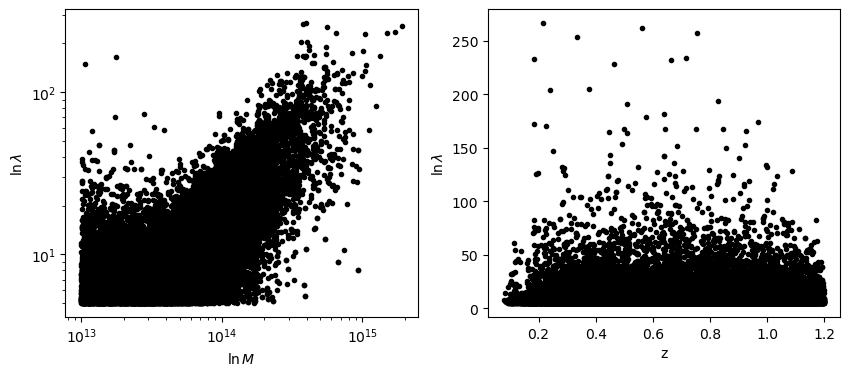

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.loglog(mass_data, rich_data, '.', c = 'k')
ax1.set(xlabel='$\ln M$', ylabel='$\ln \lambda$')

ax2.plot(z_data, rich_data, '.', c = 'k')
ax2.set(xlabel='z', ylabel='$\ln \lambda$')



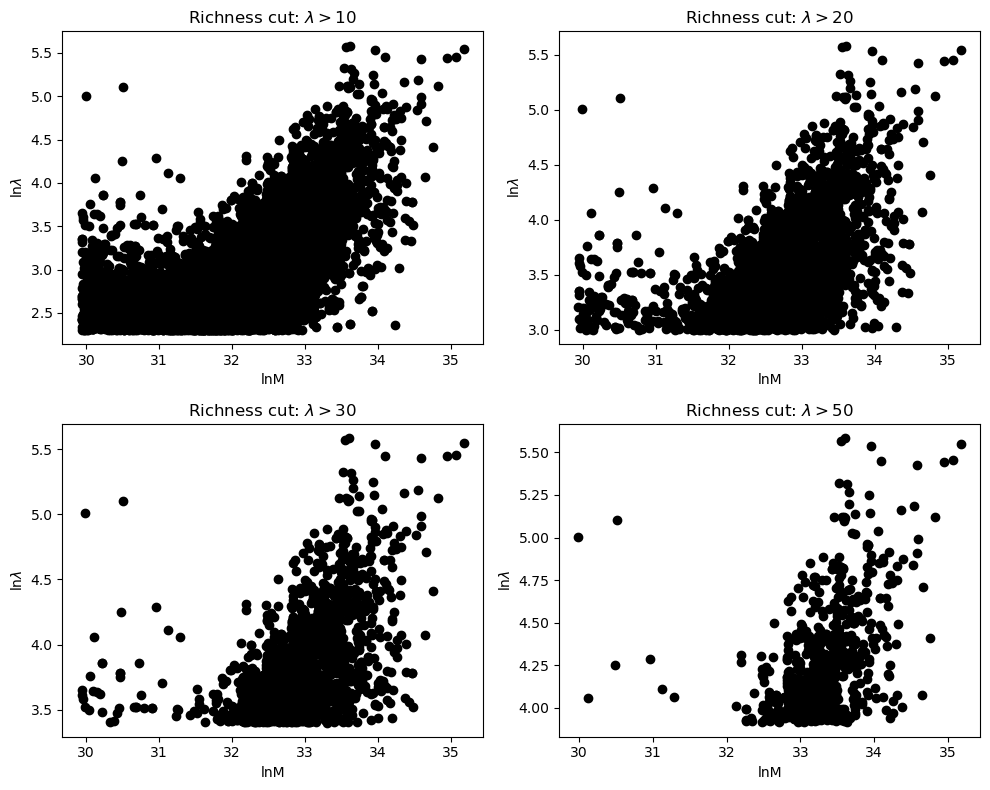

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(10,8))

rcut_list = np.array([10, 20, 30, 50])
for rcut, ax in zip(rcut_list, axs.flat):
    
    test_dt = Table([mass_data, rich_data, z_data], names=('mass', 'richness', 'redshift'))

    test_dt = test_dt[np.logical_and(test_dt['richness'] > rcut, test_dt['richness'] < 1e3)]

    mass_dt = test_dt['mass']
    red_dt = test_dt['redshift']
    rich_dt = test_dt['richness']
        
    ax.scatter(np.log(mass_dt), np.log(rich_dt), c='k')
    ax.set(xlabel='lnM', ylabel='ln$\lambda$')
    ax.set_title('Richness cut: $\lambda >$' +str(rcut) )

    fig.tight_layout()
    
    
    

In [10]:
test_dt = Table([mass_data, rich_data, z_data], names=('mass', 'richness', 'redshift'))
test_dt = test_dt[test_dt['mass'] > 1.0e13]
test_dt = test_dt[np.logical_and(test_dt['redshift'] > 0, test_dt['redshift']< 3)]
test_dt = test_dt[np.logical_and(test_dt['richness'] > 0, test_dt['richness'] < 1e3)]

mass_dt = test_dt['mass']
red_dt = test_dt['redshift']
rich_dt = test_dt['richness']

print('\t\tMin:\t\t\tMax:')
print(f'Mass:\t\t{min(mass_dt):.2e},\t\t{max(mass_dt):.2e}')
print(f'Redshift:\t{min(red_dt)},\t{max(red_dt)}')
print(f'Richness:\t{min(rich_dt)},\t\t{max(rich_dt)}')


dt_halos = test_dt

		Min:			Max:
Mass:		1.00e+13,		1.90e+15
Redshift:	0.0788790195519597,	1.1998511783121597
Richness:	5.007845,		266.29504


## Models fit

### Training and test sets

In [11]:
#Length of bins
b_z = 0.01
b_m = 0.05

In [12]:
X = pd.DataFrame({'mass': list(dt_halos["mass"]), 'redshift': list(dt_halos["redshift"])})
y = pd.DataFrame({'richness': list(dt_halos["richness"])})

fm = FittingModel(dt_halos, b_z, b_m) #Fit object

data_train = fm.cvdata(X,y)[0]
data_test = fm.cvdata(X,y)[1]

#Test  data
# data_test = pd.concat([X_test, y_test], axis=1)

# print( data_test.shape, X_test.shape, y_test.shape )
# print( data_train.shape, X_train.shape, y_train.shape )

# print( data_test.shape[0] + data_train.shape[0] )

# print( len(dt_halos) )


### Bins


In [13]:
# Bins length
bd = BinningData(dt_halos)
bin_f= bd.get_mean_bd(b_z, b_m)
halos_mean = bin_f[0]

# hbmz = bd.data_binning(b_z, b_m)

# print(f'Total bins in halos_bin_mz: {len(hbmz)}')
print(f'Total bins in halos_mean: {len(bin_f[0])}')


Total bins in halos_mean: 5586


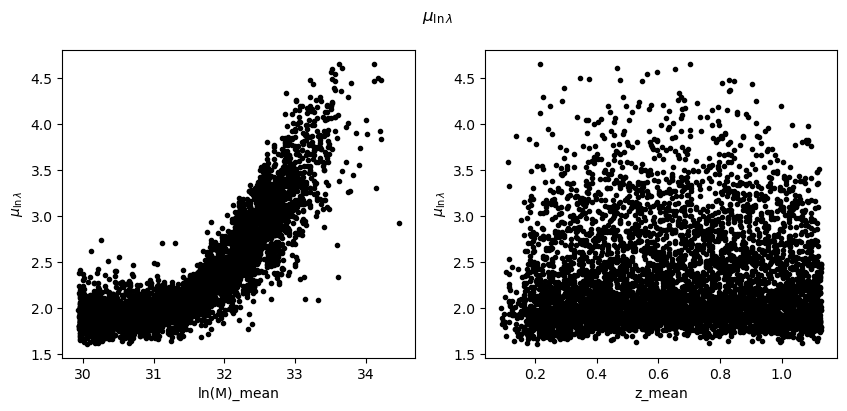

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(np.log(halos_mean['mass']), np.log(halos_mean['richness']),'.', c='k')
ax1.set(xlabel='ln(M)_mean', ylabel='$\mu_{\ln \lambda}$')

ax2.plot(halos_mean['redshift'], np.log(halos_mean['richness']),'.', c='k')
ax2.set(xlabel='z_mean', ylabel='$\mu_{\ln \lambda}$')

plt.suptitle('$\mu_{\ln \lambda}$')
plt.show()

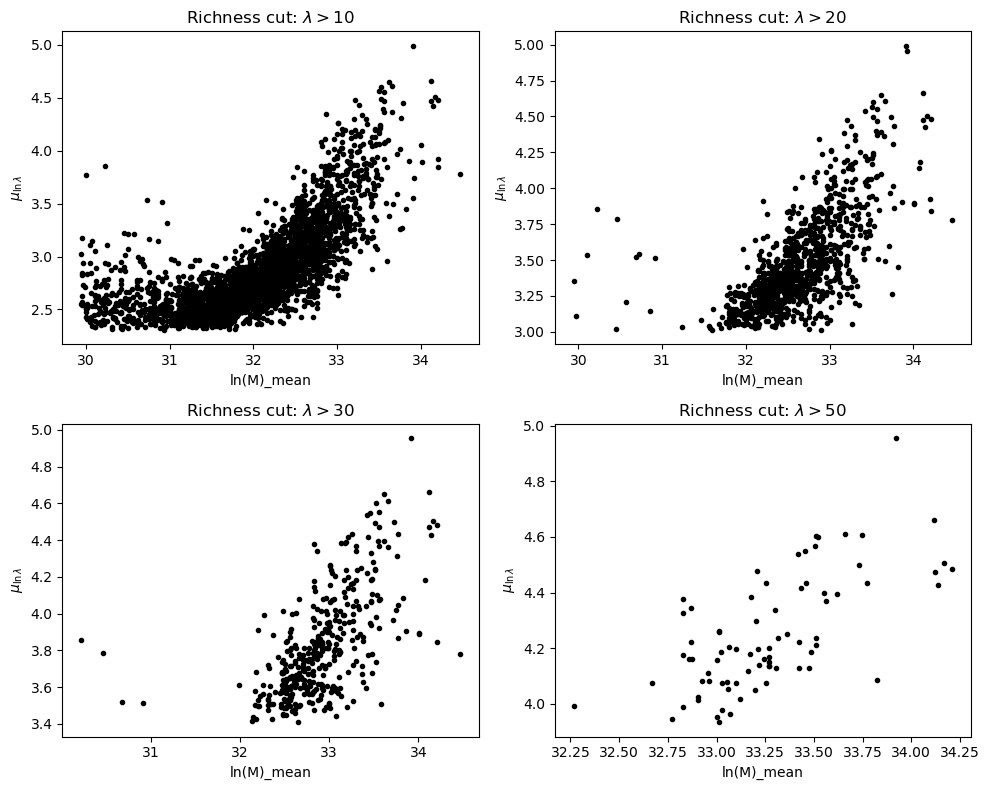

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(10,8))

rcut_list = np.array([10, 20, 30, 50])
for rcut, ax in zip(rcut_list, axs.flat):
    
    test_dt = Table([mass_data, rich_data, z_data], names=('mass', 'richness', 'redshift'))

    test_dt = test_dt[np.logical_and(test_dt['richness'] > rcut, test_dt['richness'] < 1e3)]

    bd = BinningData(test_dt)
    bin_f= bd.get_mean_bd(b_z, b_m)
    halos_mean = bin_f[0]
        
    ax.plot(np.log(halos_mean['mass']), np.log(halos_mean['richness']),'.', c='k')
    ax.set(xlabel='ln(M)_mean', ylabel='$\mu_{\ln \lambda}$')
    ax.set_title('Richness cut: $\lambda >$' +str(rcut) )

    fig.tight_layout()
    


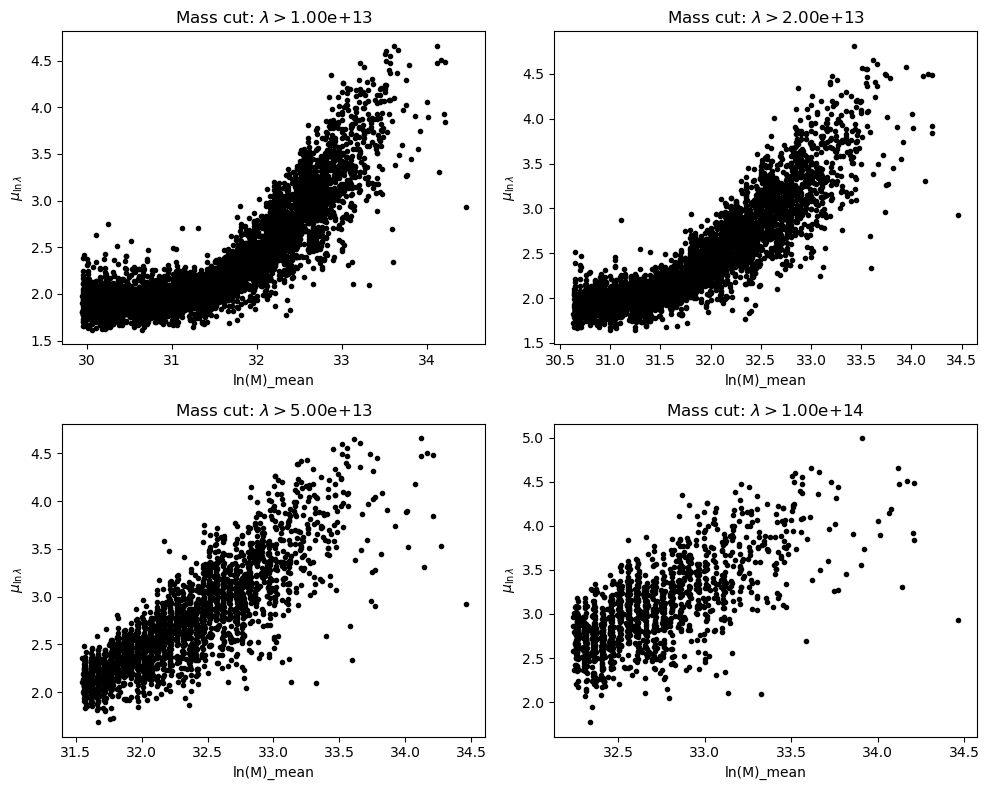

In [16]:
fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(10,8))

mcut_list = np.array([1e13, 0.2e14, 0.5e14, 1e14])
for mcut, ax in zip(mcut_list, axs.flat):
    
    test_dt = Table([mass_data, rich_data, z_data], names=('mass', 'richness', 'redshift'))

    test_dt = test_dt[np.logical_and(test_dt['mass'] > mcut, test_dt['mass'] < 1e16)]

    bd = BinningData(test_dt)
    bin_f= bd.get_mean_bd(b_z, b_m)
    halos_mean = bin_f[0]
        
    ax.plot(np.log(halos_mean['mass']), np.log(halos_mean['richness']),'.', c='k')
    ax.set(xlabel='ln(M)_mean', ylabel='$\mu_{\ln \lambda}$')
    ax.set_title('Mass cut: $\lambda >$' +'{:.2e}'.format(mcut))

    fig.tight_layout()

### Ascaso Fit Params

Here we do the fitting of linear model parameters using training data in **data_train**. The model is:

\begin{equation}
    \left< \ln R | M, z \right> = \mu_0 + \mu_1 \ln\left( \frac{M}{M_0} \right) +  \mu_2\ln\left(\frac{1 + z}{1 + z_0}\right);
\end{equation}

$$\textbf{p}_{1} = \{\mu_0, \mu_1, \mu_2, \sigma_0, \sigma_1, \sigma_2\}. $$

$\textbf{p}_{1}$ is the vector with the linear model parameters.


In [17]:
lnR_mean_ascaso, lnR_std_ascaso, ascaso, asc_mean, asc_std = fm.model_fit('ascaso', training = True)

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[09000]:
#   - NcClusterMass : Ascaso Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -    mup0[00]:  3.19                [FREE]
#   -    mup1[01]:  0.868588963806504   [FREE]
#   -    mup2[02]: -0.304006137332276   [FREE]
#   - sigmap0[03]:  0.33                [FREE]
#   - sigmap1[04]: -0.0347435585522601  [FREE]
#   - sigmap2[05]:  0                   [FREE]
#   -     cut[06]:  100                 [FIXED]
#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#........................................................

### Ext (ln(1+z)) Fit Params
Here we do the fitting of quadratic model parameters using training data in **data_train**. Dependence on $\ln (1 + z)$ is considered:

\begin{equation}\label{M_R_3}
\begin{split}
    \left<\ln R | M, z \right> = \mu_0 + 
    \mu_{M1} \ln\left( \frac{M}{M_0} \right) +
    \mu_{M2} (\ln\left(\frac{M}{M_0} \right))^2 +\\
    + \mu_{z1} \ln\left(\frac{1 + z}{1 + z_0}\right) +
    \mu_{z2} (\ln\left(\frac{1 + z}{1 + z_0}\right))^2 +\\
    + \mu_{Mz} \ln\left(\frac{1 + z}{1 + z_0}\right)\ln\left(\frac{M}{M_0} \right);
\end{split}
\end{equation}

$$\textbf{p}_{2} = \{\mu_0, \mu_{M1}, \mu_{M2}, \mu_{Z1}, \mu_{Z2}, \mu_{MZ}, \sigma_0, \sigma_{M1}, \sigma_{M2}, \sigma_{Z1}, \sigma_{Z2}, \sigma_{MZ} \}.$$

$\textbf{p}_{2}$ is the vector with the quadratic model parameters.


In [18]:
lnR_mean_ext_ln1pz, lnR_std_ext_ln1pz, ext_ln1pz, ext_mean, ext_std = fm.model_fit('ext_ln1pz', training = False)

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[09000]:
#   - NcClusterMass : LnrichExt Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -      mu[00]:  3.19                [FREE]
#   -    muM1[01]:  0.868588963806504   [FREE]
#   -    muZ1[02]: -0.304006137332276   [FREE]
#   -    muM2[03]:  0                   [FREE]
#   -    muZ2[04]:  0                   [FREE]
#   -    muMZ[05]:  0                   [FREE]
#   -  sigma0[06]:  0.33                [FREE]
#   - sigmaM1[07]: -0.0347435585522601  [FREE]
#   - sigmaZ1[08]:  0                   [FREE]
#   - sigmaM2[09]:  0                   [FREE]
#   - sigmaZ2[10]:  0                   [FREE]
#   - sigmaMZ[11]:  0                   [FREE]
#   -      A0[12]:  0                   [FIX

### Ext (z) Fit Params


Here we do the fitting of quadratic model parameters using training data in **data_train**. Dependence on $z$ is considered:

\begin{equation}\label{M_R_3}
\begin{split}
    \left<\ln R | M, z \right> = \mu_0 + 
    \mu_{M1} \ln\left( \frac{M}{M_0} \right) +
    \mu_{M2} (\ln\left(\frac{M}{M_0} \right))^2 +\\
    + \mu_{z1} \left(\frac{ z}{z_0}\right) +
    \mu_{z2} \left(\frac{z}{z_0}\right)^2 +
    \mu_{Mz} \left(\frac{z}{z_0}\right)\ln\left(\frac{M}{M_0} \right);
\end{split}
\end{equation}

$$\textbf{p}_{2} = \{\mu_0, \mu_{M1}, \mu_{M2}, \mu_{Z1}, \mu_{Z2}, \mu_{MZ}, \sigma_0, \sigma_{M1}, \sigma_{M2}, \sigma_{Z1}, \sigma_{Z2}, \sigma_{MZ} \}.$$

In [ ]:
# lnR_mean_ext_z, lnR_std_ext_z, ext_z, data_train, data_test = fm.model_fit('ext_z', training = True)

### Plot config

In [ ]:
def Plot_model(model, h_mean, h_std, mean):
    
    fig = plt.figure(figsize=(16,4))
#     gs = gridspec.GridSpec(nrows=2, ncols=2, width_ratios=[1, 1], height_ratios=[2.5, 1], wspace=0.4)
    
#     ax1 = fig.add_subplot(gs[0, :], projection='3d')
#     ax2 = fig.add_subplot(gs[1, 0])
#     ax3 = fig.add_subplot(gs[1, 1])
    ax1 = fig.add_subplot(1,3,1, projection='3d')
    ax2 = fig.add_subplot(1,3,2)
    ax3 = fig.add_subplot(1,3,3)
    
    #Mu plot config ---------------------------------------
    if mean == True:
        #lnR model, z_mean, y_mean
        lnR_mean = np.log(h_mean["richness"])
        
        print(len(lnR_mean), len(model))
        
        xs = h_mean["redshift"]
        ys = np.log(h_mean["mass"])
        zs = model

        lb_model = '<$Ln\lambda$| M, z>'
        lb_binned = 'Mean $\ln \lambda_i$'
        m = lnR_mean
        
        if f'{model}' == f'{lnR_mean_ascaso}': 
            #fig.suptitle('Modelo de Ascaso')
            fig.suptitle('$<\ln\lambda| M, z>_{LINEAR}$')
        elif f'{model}' == f'{lnR_mean_ext_ln1pz}': 
            fig.suptitle('$<\ln\lambda| M, z>_{QUADRATIC}$')
        elif f'{model}' == f'{lnR_mean_ext_z}': 
            fig.suptitle('Modelo Estendido (z)')
        else: 
            pass
    
    #Std plot config ---------------------------------------
    else:
        std_mean = h_std

        xs = h_mean["redshift"]
        ys = np.log(h_mean["mass"])
        zs = model 
        
        lb_model = '$\sigma_{\ln \lambda}$'
        lb_binned = '$\sigma^{i}$'
        m = std_mean
        
        if f'{model}' == f'{lnR_std_ascaso}': 
            fig.suptitle('Linear Model', size=16)
        elif f'{model}' == f'{lnR_std_ext_ln1pz}': 
            fig.suptitle('Quadratic Model(ln(1 + z))', size=16)
        elif f'{model}' == f'{lnR_std_ext_z}': 
            fig.suptitle('Quadratic Model (z)', size=16)
        else: 
            pass
        
    #-------------------------------------------------------
    p1 =ax1.scatter(xs, ys, zs, c=zs, cmap='cool')
    ax1.set_xlabel('z')
    ax1.set_ylabel('lnM')
    fig.colorbar(p1, ax=ax1, label= lb_model)

    ax2.scatter(ys, m, c='k', s=2.0, label=lb_binned)
    p2 = ax2.scatter(ys, zs , c= xs, s=2.0, cmap='cool')
    ax2.set_xlabel('lnM')
    ax2.set_ylabel(lb_model)
    fig.colorbar(p2, ax=ax2, label='z')
    ax2.legend()

    ax3.scatter(xs, m, c='k', s=2.0, label=lb_binned)
    p3 = ax3.scatter(xs, zs , c=ys, s=2.0, cmap='cool') 
    ax3.set_xlabel('z')
    ax3.set_ylabel(lb_model)
    fig.colorbar(p3, ax=ax3, label='lnM')
    ax3.legend()         
    plt.show()



### Mean

In [ ]:
Plot_model(lnR_mean_ascaso, asc_mean, asc_std, mean = True) #Ascaso
Plot_model(lnR_mean_ext_ln1pz, ext_mean, ext_std, mean = True) #Extended (ln(1 + z)) 
# Plot_model(lnR_mean_ext_z, data_test, mean = True)

plt.show()

### Standard deviation

In [ ]:
Plot_model(lnR_std_ascaso, asc_mean, asc_std, mean=False) #Ascaso
Plot_model(lnR_std_ext_ln1pz, ext_mean, ext_std, mean=False) #Extended (ln(1 + z)) 
#Plot_model_std(lnR_std_ext_z, data_train)

plt.show()

## Cross Validation

- Relative error:

\begin{equation}
Rel\_err = \frac{\left<\ln R_i | M_i, z_i \right> - {\mu^{i}}_{lnR}}{{\mu^{i}}_{lnR}}
\end{equation}

- Mean Square Error (MSE):

\begin{equation}
MSE = \frac{1}{N} \sum^{N} ({\mu^{i}}_{lnR} - \left<\ln R_i | M_i, z_i \right> )^2
\end{equation}

- Root Mean Square Error (RMSE):

\begin{equation}
RMSE = \sqrt{MSE}
\end{equation}


### Mean Relative Error

In [ ]:
bd_test = BinningData(data_test)
bin_f_test= bd_test.get_mean_bd(b_z, b_m)

In [ ]:
# MEAN 
halos_mean = bin_f_test[0]

lnR_test = np.log(halos_mean["richness"])
lnM_test = np.log(halos_mean["mass"])
z_test = halos_mean["redshift"]

ascaso_mean_valid = np.array( [ascaso.get_mean_richness(lnM_test[i], z_test[i]) for i in range(len(lnR_test))])
ext_ln1pz_mean_valid = np.array([ext_ln1pz.get_mean_richness(lnM_test[i], z_test[i]) for i in range(len(lnR_test))])

In [ ]:
#Relative Error: Mean

#mean relative error
re_mean_ascaso = (ascaso_mean_valid - lnR_test)/ lnR_test
re_mean_ext_ln1pz = (ext_ln1pz_mean_valid - lnR_test)/ lnR_test

#Plot
plt.scatter(ascaso_mean_valid, re_mean_ascaso, c='#a0d995', alpha=0.7, label='Ascaso')
# plt.scatter(ext_ln1pz_mean_valid, re_mean_ext_ln1pz, c='#b186f1', alpha=0.7, label='Modelo Estendido (ln(1 + z))')
plt.xlabel('Predição', size=14)
plt.ylabel('Erro Relativo', size=14)
#plt.yscale('log')
plt.axhline(y=0.0, color='black', linestyle='dotted')

plt.title('Erro relativo da média', size=14)
plt.legend()
plt.show()


In [ ]:
#Relative Error histogram

fig = plt.figure(figsize=(10,3))
ax1=plt.subplot(121)
ax2=plt.subplot(122)

ax1.hist(re_mean_ascaso, bins=70, color='#a0d995')
ax1.set_title('Ascaso')

ax2.hist(re_mean_ext_ln1pz, bins=70, color='#b186f1')
ax2.set_title('Modelo Estendido (ln(1 + z))')

plt.show()

print(f" Ascaso: p-value: {stats.kstest(re_mean_ascaso, stats.norm.cdf, args=(np.mean(re_mean_ascaso), np.std(re_mean_ascaso))).pvalue}")
print(f" Extended: p-value: {stats.kstest(re_mean_ext_ln1pz, stats.norm.cdf, args=(np.mean(re_mean_ext_ln1pz), np.std(re_mean_ext_ln1pz))).pvalue}")

### Mean MSE and RMSE

In [ ]:
# Mean Square Error(MSE)
# Root Mean Square Error(RMSE)

MSE_ascaso = sum((lnR_test - ascaso_mean_valid) ** 2) / len(ascaso_mean_valid)
RMSE_ascaso = np.sqrt(MSE_ascaso)

MSE_ext_ln1pz = sum((lnR_test - ext_ln1pz_mean_valid) ** 2) / len(ext_ln1pz_mean_valid)
RMSE_ext_ln1pz = np.sqrt(MSE_ext_ln1pz )

print(f"Mean MSE and RMSE\n\nAscaso: \tMSE: {MSE_ascaso: .3f},\t RMSE:{RMSE_ascaso: .3f}")
print(f"Extended:\tMSE: {MSE_ext_ln1pz: .3f},\t RMSE:{RMSE_ext_ln1pz: .3f}\n")

### Mean MAPE

In [ ]:
print(f"MAPE:STD\n\nMAPE (Ascaso): {mean_absolute_percentage_error(lnR_test, ascaso_mean_valid) * 100: .2f}%") 
print(f"MAPE (Extended): {mean_absolute_percentage_error(lnR_test, ext_ln1pz_mean_valid) * 100: .2f}%") 

### Std Relative Error

In [ ]:
bd_test = BinningData(data_test)
bin_f_test= bd_test.get_mean_bd(b_z, b_m)

lnR_test_std = bin_f_test[4]

ascaso_std_valid = np.array([ascaso.get_std_richness(lnM_test[i], z_test[i]) for i in range(len(lnR_test_std))])
ext_ln1pz_std_valid = np.array([ext_ln1pz.get_std_richness(lnM_test[i], z_test[i]) for i in range(len(lnR_test_std))])


In [ ]:
abs_err = (lnR_test - ascaso_mean_valid) / lnR_test_std

plt.scatter(lnM_test, abs_err)

In [ ]:
# STD 
#Relative Error: std
a_err = (ascaso_std_valid - lnR_test_std)/ lnR_test_std
e_err = (ext_ln1pz_std_valid - lnR_test_std)/ lnR_test_std

#Plot
plt.scatter(ascaso_std_valid, a_err, c='#a0d995', alpha=0.7, label='Ascaso')
plt.scatter(ext_ln1pz_std_valid, e_err, c='#b186f1', alpha=0.7, label='Modelo Estendido (ln(1 + z))')

plt.xlabel('Predição', size=14)
plt.ylabel('Erro Relativo', size=14)
plt.axhline(y=0.0, color='black', linestyle='dotted')
#plt.title('Erro relativo do desvio padrão (< 10)', size=16)
#plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
#Relative Error histogram

# fig = plt.figure(figsize=(10,3))
# ax1=plt.subplot(121)
# ax2=plt.subplot(122)

# ax1.hist(a_err, bins=70, density=True, color='#a0d995')
# ax1.set_title('Ascaso')

# ax2.hist(e_err, bins=70,density=True, color='#b186f1')
# ax2.set_title('Modelo Estendido (ln(1 + z))')

# plt.show()

# print(f" Ascaso: p-value: {stats.kstest(a_err, stats.norm.cdf, args=(np.mean(a_err), np.std(a_err))).pvalue}")
# print(f" Extended: p-value: {stats.kstest(e_err, stats.norm.cdf, args=(np.mean(e_err), np.std(e_err))).pvalue}")

### Std MSE and RMSE

In [ ]:
MSE_ascaso_std = sum((lnR_test_std - ascaso_std_valid) ** 2) / len(ascaso_std_valid)
RMSE_ascaso_std = np.sqrt(MSE_ascaso_std)

MSE_ext_ln1pz_std = sum((lnR_test_std - ext_ln1pz_std_valid) ** 2) / len(ext_ln1pz_std_valid)
RMSE_ext_ln1pz_std = np.sqrt(MSE_ext_ln1pz_std )

print(f"Std MSE and RMSE\n\nAscaso: \tMSE: {MSE_ascaso_std: .3f},\t RMSE:{RMSE_ascaso_std: .3f}")
print(f"Extended:\tMSE: {MSE_ext_ln1pz_std: .3f},\t RMSE:{RMSE_ext_ln1pz_std: .3f}\n")

### Std MAPE

In [ ]:
print(f"MAPE:STD\n\nMAPE (Ascaso): {mean_absolute_percentage_error(lnR_test_std, ascaso_std_valid) * 100: .2f}%") 
print(f"MAPE (Extended): {mean_absolute_percentage_error(lnR_test_std, ext_ln1pz_std_valid) * 100: .2f}%") 